In [22]:
from dataclasses import dataclass, field
from pathlib import Path
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter
from scipy.signal import find_peaks

In [23]:
# file_path = Path(".") / "sample_files" / "201206 - Er_TiPs2COT_I_THF2 - 1 - 2 - MvsH.dat" # 1
# file_path = Path(".") / "sample_files" / "200710 - [Er(TiPS2COT)I(THF)]2 - 2 - 1 - MvsH - VSM.dat" # 2
file_path = Path(".") / "sample_files" / "201201 - [Er_TIPS2COT_I]3 - 2 - 1 - MvsH.dat" # 3
# a relative path works best for the sample files
# use the following for an absolute path
# file_path = Path(r"/absolute/path/to/file.csv")

In [24]:
file_header: list[str] = []
with open(file_path, "r") as f:
    csv_reader = csv.reader(f)
    csv_reader.__next__()  # skip first line that just says "[Header]"
    for row in csv_reader:
        if "[Data]" in row:
            break
        else:
            file_header.append(row)

In [25]:
# the following uses some Rinehart group specific conventions for using the fields in the header
sample_info: dict[str, float] = {}
for line in file_header:
    if line[0] == "INFO" and line[2] == "SAMPLE_MASS" and line[1]:
        sample_info["mass"] = float(line[1])
    elif line[0] == "INFO" and line[2] == "SAMPLE_VOLUME" and line[1]:
        sample_info["eicosane_mass"] = float(line[1])
    elif line[0] == "INFO" and line[2] == "SAMPLE_MOLECULAR_WEIGHT" and line[1]:
        sample_info["molecular_weight"] = float(line[1])
    elif line[0] == "INFO" and line[2] == "SAMPLE_SIZE" and line[1]:
        sample_info["diamagnetic_correction"] = float(line[1])
if sample_info["mass"] and sample_info["molecular_weight"]:
    sample_info['mol'] = (sample_info["mass"] / 1000) / sample_info["molecular_weight"]
sample_info

{'mass': 17.3,
 'eicosane_mass': 29.3,
 'molecular_weight': 2176.1,
 'diamagnetic_correction': -0.0011077,
 'mol': 7.950002297688525e-06}

In [26]:
data = pd.read_csv(file_path, skiprows=len(file_header) + 2)
data

,Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Moment (emu),M. Std. Err. (emu),Transport Action,Averaging Time (sec),Frequency (Hz),Peak Amplitude (mm),...,Map 07,Map 08,Map 09,Map 10,Map 11,Map 12,Map 13,Map 14,Map 15,Map 16
0,NaN,3.815951e+09,1.999939,69999.632812,0.651303,0.000504,1,1,13.006381,0.999158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,3.815951e+09,1.999911,69999.578125,0.650937,0.000347,1,1,13.006381,0.999177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.815951e+09,2.000133,69743.375000,0.651449,0.000457,1,1,13.006381,0.999188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,3.815951e+09,2.000031,69289.984375,0.651693,0.000683,1,1,13.006381,0.999170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.815951e+09,2.000044,69245.406250,0.651531,0.000509,1,1,13.006381,0.999170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,NaN,3.815957e+09,1.999945,69003.335938,0.651450,0.000617,1,1,13.006381,0.999153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1120,NaN,3.815957e+09,2.000065,69254.867188,0.651117,0.000486,1,1,13.006381,0.999138,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1121,NaN,3.815957e+09,2.000147,69501.234375,0.650631,0.000466,1,1,13.006381,0.999158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122,NaN,3.815957e+09,1.999953,69752.710938,0.651059,0.000440,1,1,13.006381,0.999153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# determine if file contains VSM or dc data, set that to a generic "moment" column
if data["DC Moment Free Ctr (emu)"].notnull().values.sum() != 0:
    data["uncorrected_moment_emu"] = data["DC Moment Free Ctr (emu)"]
    data['uncorrected_moment_error'] = data['DC Moment Err Free Ctr (emu)']
elif data["Moment (emu)"].notnull().values.sum() != 0:
    data["uncorrected_moment_emu"] = data["Moment (emu)"] 
    data['uncorrected_moment_error'] = data['M. Std. Err. (emu)']
# now let's prune the dataframe and simplify column names
old_data = data.copy()
data = pd.DataFrame()
names = {
        "time": "Time Stamp (sec)",
        "temperature": "Temperature (K)",
        "field": "Magnetic Field (Oe)",
        "uncorrected_moment_emu": "uncorrected_moment_emu",
        "uncorrected_moment_error": "uncorrected_moment_error",
}
for new_name, old_name in names.items():
    data[new_name] = old_data[old_name]
data

,time,temperature,field,uncorrected_moment_emu,uncorrected_moment_error
0,3.815951e+09,1.999939,69999.632812,0.651303,0.000504
1,3.815951e+09,1.999911,69999.578125,0.650937,0.000347
2,3.815951e+09,2.000133,69743.375000,0.651449,0.000457
3,3.815951e+09,2.000031,69289.984375,0.651693,0.000683
4,3.815951e+09,2.000044,69245.406250,0.651531,0.000509
...,...,...,...,...,...
1119,3.815957e+09,1.999945,69003.335938,0.651450,0.000617
1120,3.815957e+09,2.000065,69254.867188,0.651117,0.000486
1121,3.815957e+09,2.000147,69501.234375,0.650631,0.000466
1122,3.815957e+09,1.999953,69752.710938,0.651059,0.000440


In [28]:
data['moment_emu'] = (
    (
        (data['uncorrected_moment_emu']/data['field'] )
        - sample_info['diamagnetic_correction']*sample_info['mol']
    ) * data['field']
)
data['moment'] = data['moment_emu']/sample_info['mol'] / 5585

data

,time,temperature,field,uncorrected_moment_emu,uncorrected_moment_error,moment_emu,moment
0,3.815951e+09,1.999939,69999.632812,0.651303,0.000504,0.651920,14.682627
1,3.815951e+09,1.999911,69999.578125,0.650937,0.000347,0.651554,14.674378
2,3.815951e+09,2.000133,69743.375000,0.651449,0.000457,0.652063,14.685862
3,3.815951e+09,2.000031,69289.984375,0.651693,0.000683,0.652303,14.691253
4,3.815951e+09,2.000044,69245.406250,0.651531,0.000509,0.652141,14.687608
...,...,...,...,...,...,...,...
1119,3.815957e+09,1.999945,69003.335938,0.651450,0.000617,0.652058,14.685736
1120,3.815957e+09,2.000065,69254.867188,0.651117,0.000486,0.651727,14.678284
1121,3.815957e+09,2.000147,69501.234375,0.650631,0.000466,0.651243,14.667376
1122,3.815957e+09,1.999953,69752.710938,0.651059,0.000440,0.651673,14.677078


In [29]:
# now we need to break up the data into separate dataframes for each temperature

# start with some helper functions
def unique_values_w_rounding(x: list, tolerance) -> list[float]:
    """Returns a list of unique values in `x` where the values are considered equal
    if they are within `tolerance` of each other.

    Examples:
    ```
    >>>_unique_values_w_rounding([5, 5.1, 4.9, 300.1, 299.6, 300.2], 1)
    [5, 300]
    ```
    """
    return list({round(i / tolerance) * tolerance for i in x})

def find_section_starts(x: pd.Series, fluctuation_tolerance: float = 0) -> list[int]:
    """Find the indices of the start of each section in a series of data,
    where a section is defined as a series of identical numbers (within the `fluctuation_tolerance`).

    Example:
    ```
    >>>x = pd.Series([1, 1, 1, 1, 2, 2, 2, 2])
    >>>_find_sequence_starts(x)
    [0, 4]

    >>>y = pd.Series([1, 1.01, 0.95, 1.07, 1.03, 2.01, 2.01, 2.02, 1.92])
    >>>_find_sequence_starts(y, 0.5)
    [0, 5]
    ```
    """
    values = unique_values_w_rounding(x, fluctuation_tolerance)
    df = pd.DataFrame({"x": x})
    for value in values:
        df[f"{value}"] = df["x"].mask(
            abs(df["x"] - value) < fluctuation_tolerance, value
        )
        df[f"{value}"] = df[f"{value}"].mask(
            abs(df["x"] - value) > fluctuation_tolerance, 0
        )
    df.drop(columns=["x"], inplace=True)
    df["y"] = sum([df[f"{value}"] for value in values])
    section_starts = [0]
    for i in df.index[1:]:
        if df["y"][i] != df["y"][i - 1]:
            section_starts.append(i)
    return section_starts

In [30]:
section_starts = find_section_starts(data["temperature"], fluctuation_tolerance=0.25)
section_starts

[0]

In [31]:
# the following classes will store/organize the data and fit results.

@dataclass
class Sequence:
    sequence_type: str
    data: pd.DataFrame

@dataclass
class CauchyParams:
    m_sat: float
    h_c: float
    gamma: float
    chi_pd: float

@dataclass
class FitResults:
    cauchy_terms: list[CauchyParams]
    sum_of_squares: float

@dataclass
class Measurement:
    temperature: float
    data: pd.DataFrame
    sequences: list[Sequence] = field(default_factory=list)
    fit_results: list[FitResults] = field(default_factory=list)

In [32]:
# create a list of dataframes, one for each temperature
measurements: list[Measurement] = []
for i, _ in enumerate(section_starts):
    try:
        df = data.iloc[section_starts[i] : section_starts[i + 1]]
    except IndexError:
        df = data.iloc[section_starts[i] :]
    avg_temp = df["temperature"].mean()
    measurements.append(Measurement(avg_temp, df))
# reset the index of each dataframe
for meas in measurements:
    meas.data.reset_index(drop=True, inplace=True)

In [33]:
measurements[0].data

,time,temperature,field,uncorrected_moment_emu,uncorrected_moment_error,moment_emu,moment
0,3.815951e+09,1.999939,69999.632812,0.651303,0.000504,0.651920,14.682627
1,3.815951e+09,1.999911,69999.578125,0.650937,0.000347,0.651554,14.674378
2,3.815951e+09,2.000133,69743.375000,0.651449,0.000457,0.652063,14.685862
3,3.815951e+09,2.000031,69289.984375,0.651693,0.000683,0.652303,14.691253
4,3.815951e+09,2.000044,69245.406250,0.651531,0.000509,0.652141,14.687608
...,...,...,...,...,...,...,...
1119,3.815957e+09,1.999945,69003.335938,0.651450,0.000617,0.652058,14.685736
1120,3.815957e+09,2.000065,69254.867188,0.651117,0.000486,0.651727,14.678284
1121,3.815957e+09,2.000147,69501.234375,0.650631,0.000466,0.651243,14.667376
1122,3.815957e+09,1.999953,69752.710938,0.651059,0.000440,0.651673,14.677078


In [34]:
# indicate the virgin, reverse, and forward parts of the measurement

# here's a helper function to determine where those sections start
def find_sequence_starts(x: pd.Series, flucuation_tolerance: float = 0) -> list[int]:
    """Find the indices of the start of each sequence in a series of data,
    where a sequences is defined as a series of numbers that constantly increase or decrease.
    Changes below `fluctuation_tolerance` are ignored.

    Example:
    ```
    >>>x = pd.Series([0, 1, 2, 3, 4, 3, 2, 1])
    >>>_find_sequence_starts(x)
    [0, 5]

    >>>y = pd.Series([0, 1, 2, 3, 0, 1, 2, 3])
    >>>_find_sequence_starts(y)
    [0, 4]
    ```
    """
    df = pd.DataFrame({"x": x, "diff": x.diff()})
    df["direction"] = np.where(df["diff"] > 0, 1, -1)
    start: int = df.index.start
    df.at[start, "direction"] = df.at[
        start + 1, "direction"
    ]  # since the first value of diff is NaN
    # if there's a really small diff value with the opposite sign of diff values around it, it's probably a mistake
    sequence_starts = [0]
    for i in df[start + 2 :].index:
        last2_dir = df.at[i - 2, "direction"]
        last1_dir = df.at[i - 1, "direction"]
        current_dir = df.at[i, "direction"]
        try:
            next1_dir = df.at[i + 1, "direction"]
            next2_dir = df.at[i + 2, "direction"]
            next3_dir = df.at[i + 3, "direction"]
        except KeyError:
            # reached end of dataframe
            break

        # below handles, for example, zfc from 5 to 300 K, drop temp to 5 K, fc from 5 to 300 K
        if (current_dir != last1_dir) and (current_dir != next1_dir):
            if abs(df.at[i, "diff"]) < flucuation_tolerance:
                # this is a fluctuation and should be ignored
                df.at[i, "direction"] = last1_dir
                current_dir = last1_dir
            else:
                sequence_starts.append(i)

        # below handles, for example, zfc from 5 to 300 K, fc from 300 to 5 K
        # assumes there won't be any fluctuations at the beginning of a sequence
        if (
            (last2_dir == last1_dir)
            and (current_dir != last1_dir)
            and (current_dir == next1_dir == next2_dir == next3_dir)
        ):
            sequence_starts.append(i)

    return sequence_starts

In [35]:
""" 
Account for 3 possible cases:
1. virgin, reverse, forward (3 sequences)
2. reverse, forward (or vice versa) (2 sequences)
3. reverse or forward (1 sequence)
"""

for meas in measurements:
    sequence_starts = find_sequence_starts(meas.data["field"])
    if len(sequence_starts) == 3:
        meas.sequences.append(
            Sequence("virgin", meas.data.iloc[sequence_starts[0] : sequence_starts[1]])
        )
        meas.sequences.append(
            Sequence("reverse", meas.data.iloc[sequence_starts[1] : sequence_starts[2]])
        )
        meas.sequences.append(
            Sequence("forward", meas.data.iloc[sequence_starts[2] :])
        )
    elif len(sequence_starts) == 2:
        # check if the first sequence is reverse or forward
        if meas.data.at[sequence_starts[0], "field"] > meas.data.at[sequence_starts[1], "field"]:
            seq_order = ["reverse", "forward"]
        else:
            seq_order = ["forward", "reverse"]
        meas.sequences.append(
            Sequence(seq_order[0], meas.data.iloc[sequence_starts[0] : sequence_starts[1]])
        )
        meas.sequences.append(
            Sequence(seq_order[1], meas.data.iloc[sequence_starts[1] :])
        )
    elif len(sequence_starts) == 1:
        # check if the sequence is reverse or forward
        if meas.data.at[sequence_starts[0], "field"] > meas.data.at[sequence_starts[0] + 1, "field"]:
            meas.sequences.append(Sequence("reverse", meas.data))
        else:
            meas.sequences.append(Sequence("forward", meas.data))

We'll now fit the data to a model consisting of multiple Cauchy distributions. The model is defined as:
\begin{equation}
M\left(H; H_c, \gamma\right) = \sum_{n=1}^{\infty} \left[{\frac{2M_n}{\pi}arctan\left(\frac{H-H_{c,n}}{\gamma_n}\right)} \right] + \chi_{pd,n}H
\end{equation}
where $M_s$ is the saturation magnetization, $H_c$ is the coercivity, $\gamma$ is the half-width at half-max of the susceptibility, and $\chi_{pd}$ is the combined contributions from paramagnetic and diamagnetic susceptibilities. 

The fit is performed by adding Cauchy terms one at a time. The sum of squares of the $n+1$ term is compared to that of the $n$ term. If the sum of squares is reduced by a certain amount (10% by default), the term is added to the model. The fit is terminated when the sum of squares is no longer reduced by the specified amount.

In [36]:
single_df = pd.DataFrame()

for meas in measurements:
    df = pd.DataFrame()
    for seq in meas.sequences:
        if seq.sequence_type == "virgin":
            continue
        elif seq.sequence_type == "reverse":
            df_rev = pd.DataFrame()
            df_rev["field"] = seq.data["field"] * -1
            df_rev["moment"] = seq.data["moment"] * -1
            df = pd.concat([df, df_rev])
        else:
            df_fwd = pd.DataFrame()
            df_fwd["field"] = seq.data["field"]
            df_fwd["moment"] = seq.data["moment"]
            df = pd.concat([df, df_fwd])
    

    single_df = df
    break

(-15000.0, 15000.0)

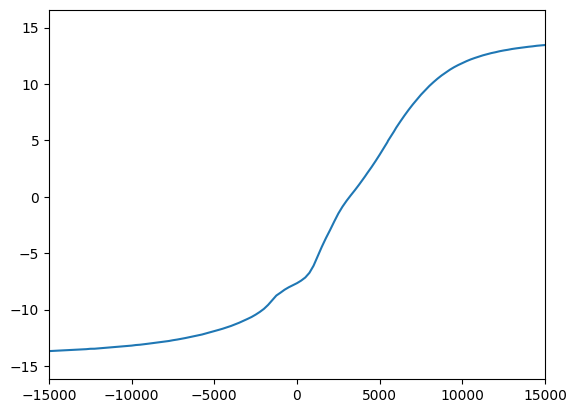

In [37]:
# test = single_df.copy()
for seq in measurements[0].sequences:
    if seq.sequence_type == "forward":
        test = seq.data.copy()
        break
fig, ax = plt.subplots()
ax.plot(test["field"], test["moment"])
ax.set_xlim(-15000, 15000)

In [38]:
def cauchy(h: float, m_s: float, h_c: float, gamma: float, m_offest: float = 0, chi_pd: float = 0):
    return (2*m_s/np.pi) * np.arctan((h-h_c)/gamma) + chi_pd*h + m_offest

In [39]:
h = np.linspace(test['field'].min(), test['field'].max(), 1000)

In [40]:
@dataclass
class CauchyParams:
    m_s: float | tuple[float, float, float] = 0.0 # either an inital value or (initial_value, min, max)
    h_c: float | tuple[float, float, float] = 0.0
    gamma: float | tuple[float, float, float] = 0.0

    def rewrite_as_tuples(self):
        if isinstance(self.m_s, float | int):
            self.m_s = (self.m_s, 0, 1)
        elif isinstance(self.m_s, tuple):
            if len(self.m_s) != 3:
                raise ValueError("m_s must be a tuple of length 3")
        if isinstance(self.h_c, float | int):
            self.h_c = (self.h_c, -700000, 700000)
        elif isinstance(self.h_c, tuple):
            if len(self.h_c) != 3:
                raise ValueError("h_c must be a tuple of length 3")
        if isinstance(self.gamma, float | int):
            self.gamma = (self.gamma, 0, 100000)

def build_params(cauchy_params: list[CauchyParams]) -> list[Parameter]:
    params = Parameters()
    for i, cauchy_param in enumerate(cauchy_params):
        cauchy_param.rewrite_as_tuples()
        params.add(f"m_s_{i}", value=cauchy_param.m_s[0], min=cauchy_param.m_s[1], max=cauchy_param.m_s[2])
        params.add(f"h_c_{i}", value=cauchy_param.h_c[0], min=cauchy_param.h_c[1], max=cauchy_param.h_c[2])
        params.add(f"gamma_{i}", value=cauchy_param.gamma[0], min=cauchy_param.gamma[1], max=cauchy_param.gamma[2])
    params.add("chi_pd", value=0, min=-1, max=1)
    return params

def cauchy_cdf(h: float, params: Parameters):
    try:
        m = h * params["chi_pd"]
    except KeyError:
        m = 0
    m += (2*params["m_s"]/np.pi) * np.arctan((h-params["h_c"])/params["gamma"])
    return m

def multi_cauchy_cdf(h: float, params: Parameters):
    # `cauchy_params` contains [m_s_0, h_c_0, gamma_0, m_s_1, h_c_1, gamma_1, ..., chi_pd]
    try:
        m = h * params["chi_pd"]
    except KeyError:
        m = 0
    for i in range(0, len(params)-1, 3):
        j = i//3
        m += (2*params[f"m_s_{j}"]/np.pi) * np.arctan((h-params[f"h_c_{j}"])/params[f"gamma_{j}"])
    return m


def multi_cauchy_cdf_residual(params: Parameters, h: float, data: float):
    # `cauchy_params` contains [m_s_0, h_c_0, gamma_0, m_s_1, h_c_1, gamma_1, ..., chi_pd]
    m = multi_cauchy_cdf(h, params)
    return m - data

In [41]:
cauchy_params = [CauchyParams(1/3, -1500, 500), CauchyParams(1/3, 1500, 500), CauchyParams(1/3, 5750, 500)]
params = build_params(cauchy_params)
out = minimize(multi_cauchy_cdf_residual, params, args=(test['field'], test['moment']/test['moment'].max()))
out.params

name,value,standard error,relative error,initial value,min,max,vary
m_s_0,0.20987478,0.01718290,(8.19%),0.3333333333333333,0.00000000,1.00000000,True
h_c_0,-1978.64194,256.820534,(12.98%),-1500,-700000.000,700000.000,True
gamma_0,3349.72152,108.186743,(3.23%),500,0.00000000,100000.000,True
m_s_1,0.32864430,0.02068457,(6.29%),0.3333333333333333,0.00000000,1.00000000,True
h_c_1,1960.07933,34.4478349,(1.76%),1500,-700000.000,700000.000,True
gamma_1,1183.03787,87.1068895,(7.36%),500,0.00000000,100000.000,True
m_s_2,0.44210454,0.00896263,(2.03%),0.3333333333333333,0.00000000,1.00000000,True
h_c_2,6235.09211,41.0612082,(0.66%),5750,-700000.000,700000.000,True
gamma_2,1851.04986,30.0921385,(1.63%),500,0.00000000,100000.000,True
chi_pd,8.2870e-08,2.7726e-08,(33.46%),0,-1.00000000,1.00000000,True


In [42]:
type(out)

lmfit.minimizer.MinimizerResult

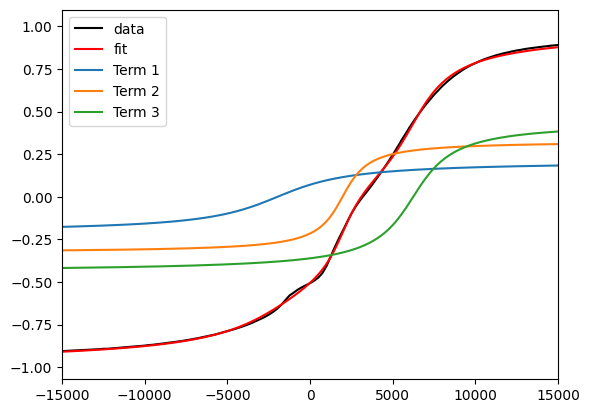

In [43]:
fig, ax = plt.subplots()
ax.plot(test['field'], test['moment']/test['moment'].max(), label='data', color='black')
ax.plot(h, multi_cauchy_cdf(h, out.params), label='fit', color='red')
ax.set_xlim(-15000, 15000)

for i in range(0, len(out.params)-1, 3):
    j = i//3
    params = Parameters()
    params.add(f"m_s", value=out.params[f"m_s_{j}"])
    params.add(f"h_c", value=out.params[f"h_c_{j}"])
    params.add(f"gamma", value=out.params[f"gamma_{j}"])
    ax.plot(h, cauchy_cdf(h, params), label=f"Term {j+1}")

ax.legend()

In [44]:
normalized_data = test['moment'] / test['moment'].max()

def triple_cauchy(
    h: float,
    m1: float,
    h_c1: float,
    gamma1: float,
    m2: float,
    h_c2: float,
    gamma2: float,
    m3: float,
    h_c3: float,
    gamma3: float,
    chi_pd: float):

    return (
        (
            (m1 * np.arctan((h-h_c1)/gamma1)) +
            (m2 * np.arctan((h-h_c2)/gamma2)) +
            (m3 * np.arctan((h-h_c3)/gamma3))
        ) + chi_pd*h
    )
def residual_triple(params, x, data):
    m1 = params['m1']
    h_c1 = params['h_c1']
    gamma1 = params['gamma1']
    m2 = params['m2']
    h_c2 = params['h_c2']
    gamma2 = params['gamma2']
    m3 = params['m3']
    h_c3 = params['h_c3']
    gamma3 = params['gamma3']
    chi_pd = params['chi_pd']
    model = triple_cauchy(x, m1, h_c1, gamma1, m2, h_c2, gamma2, m3, h_c3, gamma3, chi_pd)
    return model - data

params = Parameters()
# params.add_many(
#     ('m1', 1/3, True, 0, 1),
#     ('h_c1', 0, True, field_range[0], field_range[1]),
#     ('gamma1', 500, True, 0, None),
#     ('m2', 1/3, True, 0, 1),
#     ('h_c2', 0, True, field_range[0], field_range[1]),
#     ('gamma2', 500, True, 0, None),
#     ('m3', 1/3, True, 0, 1),
#     ('h_c3', 0, True, field_range[0], field_range[1]),
#     ('gamma3', 500, True, 0, None),
#     ('chi_pd', 0, True, None, None),
# )
params.add_many(
    ('m1', 1/3, True, 0, 1),
    ('h_c1', -1500, True, -1500*1.5, -1500*.5),
    ('gamma1', 500, True, 0, None),
    ('m2', 1/3, True, 0, 1),
    ('h_c2', 1500, True, 1500*.5, 1500*1.5),
    ('gamma2', 500, True, 0, None),
    ('m3', 1/3, True, 0, 1),
    ('h_c3', 5750, True, 5750*.5, 5750*1.5),
    ('gamma3', 500, True, 0, None),
    ('chi_pd', 0, True, None, None),
)
# params.add_many(
#     ('m1', 0.075, True, 0, 1),
#     ('h_c1', -1500, True, -1500*1.5, -1500*.5),
#     ('gamma1', 500, True, 0, None),
#     ('m2', 0.4, True, 0, 1),
#     ('h_c2', 1500, True, 1500*.5, 1500*1.5),
#     ('gamma2', 1500, True, 0, None),
#     ('m3', 1-.075-.4, True, 0, 1),
#     ('h_c3', 5750, True, 5750*.5, 5750*1.5),
#     ('gamma3', 500, True, 0, None),
#     ('chi_pd', 0, True, None, None),
# )

out = minimize(residual_triple, params, method='leastsq', args=(test['field'], normalized_data))
out.params

name,value,standard error,relative error,initial value,min,max,vary
m1,0.13361070,0.01093778,(8.19%),0.3333333333333333,0.00000000,1.00000000,True
h_c1,-1978.66898,256.844544,(12.98%),-1500,-2250.00000,-750.000000,True
gamma1,3349.68782,108.185847,(3.23%),500,0.00000000,inf,True
m2,0.20921784,0.01316704,(6.29%),0.3333333333333333,0.00000000,1.00000000,True
h_c2,1960.06901,34.4450420,(1.76%),1500,750.000000,2250.00000,True
gamma2,1183.00918,87.1013886,(7.36%),500,0.00000000,inf,True
m3,0.28145568,0.00570558,(2.03%),0.3333333333333333,0.00000000,1.00000000,True
h_c3,6235.07300,41.0604659,(0.66%),5750,2875.00000,8625.00000,True
gamma3,1851.06095,30.0910265,(1.63%),500,0.00000000,inf,True
chi_pd,8.2877e-08,2.9912e-08,(36.09%),0,-inf,inf,True


In [45]:
len(params)

10

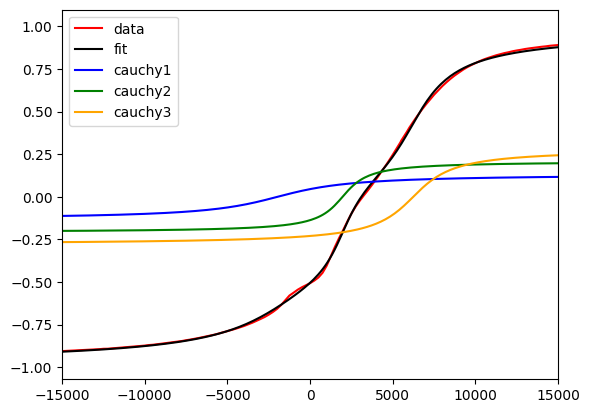

In [46]:
fig, ax = plt.subplots()
ax.plot(test["field"], normalized_data, color='red', label = 'data')
h = np.linspace(test['field'].min(), test['field'].max(), 1000)
ax.plot(h, triple_cauchy(
    h,
    out.params['m1'].value,
    out.params['h_c1'].value,
    out.params['gamma1'].value,
    out.params['m2'].value,
    out.params['h_c2'].value,
    out.params['gamma2'].value,
    out.params['m3'].value,
    out.params['h_c3'].value,
    out.params['gamma3'].value,
    out.params['chi_pd'].value
), color = 'black', label = 'fit')
ax.set_xlim(-15000, 15000)
ax.plot(h, cauchy(
    h,
    out.params['m1'].value,
    out.params['h_c1'].value,
    out.params['gamma1'].value,
), color = 'blue', label = 'cauchy1')
ax.plot(h, cauchy(
    h,
    out.params['m2'].value,
    out.params['h_c2'].value,
    out.params['gamma2'].value,
), color = 'green', label = 'cauchy2')
ax.plot(h, cauchy(
    h,
    out.params['m3'].value,
    out.params['h_c3'].value,
    out.params['gamma3'].value,
), color = 'orange', label = 'cauchy3')
# ax.plot(h, out.params['chi_pd'].value*h)
ax.legend()
# ax.vlines(out.params['h_c1'].value, -1, 1, color = 'blue')
# ax.vlines(out.params['h_c2'].value, -1, 1, color = 'green')
# ax.vlines(out.params['h_c3'].value, -1, 1, color = 'orange')

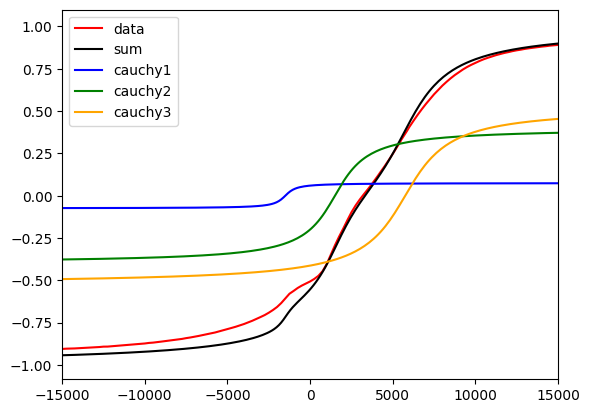

In [47]:
fig, ax = plt.subplots()
m_s = test['moment'].max()
ax.plot(test["field"], test["moment"]/m_s, color='red', label = 'data')
ax.set_xlim(-15000, 15000)
h = np.linspace(test['field'].min(), test['field'].max(), 1000)
cauchy1 = cauchy(h, 0.075, -1500, 500, 0) # -7
cauchy2 = cauchy(h, 0.4, 1500, 1500, 0) # 3
cauchy3 = cauchy(h, 1-(0.075 + 0.4), 5750, 2000, 0) # 4
ax.plot(h, cauchy1 + cauchy2 + cauchy3, color='black', label = 'sum')
ax.plot(h, cauchy1, color = 'blue', label = 'cauchy1')
ax.plot(h, cauchy2, color = 'green', label = 'cauchy2')
ax.plot(h, cauchy3, color = 'orange', label = 'cauchy3')
ax.legend()


(-0.000321936090977186, 0.0035412970007490463)

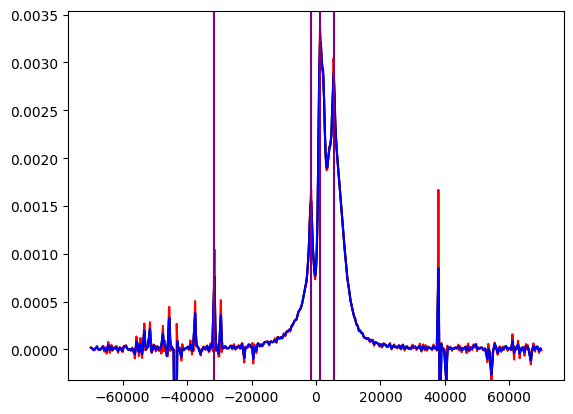

In [54]:
dtest = test.copy()
dtest.reset_index(inplace=True)
fig, ax = plt.subplots()

dtest['dmoment'] = np.gradient(dtest['moment'], dtest['field'])
ax.plot(dtest["field"], dtest["dmoment"], color='red')
# smooth with triangle window, median filter, window size 3
dtest['dmoment'] = dtest['dmoment'].rolling(3, center=True, win_type='triang').mean()
# dtest['dmoment_smooth'] = dtest['dmoment'].rolling(3, center=True).median()
ax.plot(dtest["field"], dtest["dmoment"], color='black')

# dtest['dmoment'] = dtest['moment'].diff() / dtest['field'].diff()
# dtest['dmoment'] = dtest['dmoment'].rolling(3, center=True).median()
ax.plot(dtest["field"], dtest["dmoment"], color='blue')
peaks, _ = find_peaks(dtest['dmoment'], height=dtest['dmoment'].max()*0.2, width = 2)
for peak in peaks:
    ax.vlines(dtest['field'][peak], -dtest['dmoment'].max()*0.1, dtest['dmoment'].max()*1.1, color = 'purple')
# ax.set_xlim(-15000, 15000)
ax.set_ylim(-dtest['dmoment'].max()*0.1, dtest['dmoment'].max()*1.1)

In [ ]:
def cauchy_pdf(h, m, h_c, gamma):
    return (4*m/np.pi) * (gamma/2) / (4 * (h - h_c)**2 + (gamma/2)**2)

In [60]:
dtest['field'][peaks].tolist()

[-31533.8837890625, -1492.04553222656, 1252.74133300781, 5507.234375]